### Deep Learning:Vehicle Tracking

In [1]:
import glob 
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure

In [8]:
cars = glob.glob("/home/octo/Desktop/vehicles/vehicles/*/*.png")
non_cars = glob.glob("/home/octo/Desktop/non-vehicles/non-vehicles/*/*.png")

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

# Read X Vector
X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars:    
    X.append(skimage.io.imread(name))
X = np.array(X)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


### Convolution2D

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) # This was Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) # This was Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("/home/octo/Desktop/localize.h5")

Using TensorFlow backend.


Train on 15984 samples, validate on 1776 samples
Epoch 1/20
15984/15984 [==============================] - 46s - loss: 0.5180 - acc: 0.5015 - val_loss: 0.1833 - val_acc: 0.8468
Epoch 2/20
15984/15984 [==============================] - 44s - loss: 0.1870 - acc: 0.8534 - val_loss: 0.0961 - val_acc: 0.9088
Epoch 3/20
15984/15984 [==============================] - 48s - loss: 0.1197 - acc: 0.9081 - val_loss: 0.0973 - val_acc: 0.9155
Epoch 4/20
15984/15984 [==============================] - 49s - loss: 0.0887 - acc: 0.9347 - val_loss: 0.0441 - val_acc: 0.9640
Epoch 5/20
15984/15984 [==============================] - 54s - loss: 0.0745 - acc: 0.9449 - val_loss: 0.0862 - val_acc: 0.9279
Epoch 6/20
15984/15984 [==============================] - 53s - loss: 0.0632 - acc: 0.9542 - val_loss: 0.0355 - val_acc: 0.9707
Epoch 7/20
15984/15984 [==============================] - 54s - loss: 0.0526 - acc: 0.9620 - val_loss: 0.0291 - val_acc: 0.9780
Epoch 8/20
15984/15984 [==============================]

In [12]:
heatmodel = get_conv(input_shape=(None,None,3), filename="/home/octo/Desktop/localize.h5")

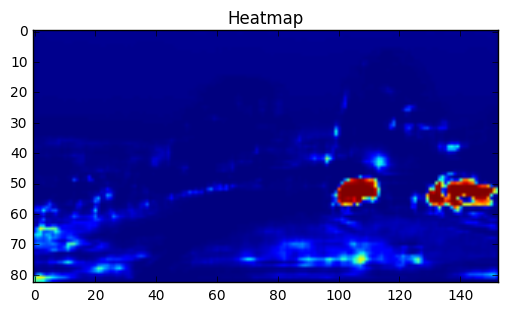

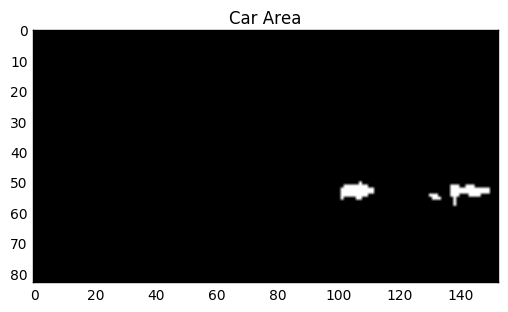

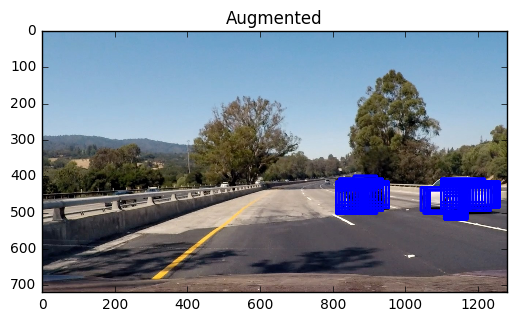

In [17]:
%matplotlib inline
import matplotlib.pylab as plt

def locate():
    data = (skimage.io.imread("/home/octo/Desktop/test_images/test4.jpg"))
    
    heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Heatmap")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Car Area")
    plt.show()

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    for i,j in zip(x,y):
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

annotated = locate()

plt.title("Augmented")    
plt.imshow(annotated)
plt.show()

#### Another method

https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/customlayers.py

### Softmax4D

In [20]:
import numpy as np
from keras.layers.core import  Lambda, Merge
from keras.layers.convolutional import Convolution2D
from keras import backend as K

from keras.engine import Layer

def crosschannelnormalization(alpha = 1e-4, k=2, beta=0.75, n=5,**kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        b, ch, r, c = X.shape
        half = n // 2
        square = K.square(X)
        extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0,2,3,1))
                                              , (0,half))
        extra_channels = K.permute_dimensions(extra_channels, (0,3,1,2))
        scale = k
        for i in range(n):
            scale += alpha * extra_channels[:,i:i+ch,:,:]
        scale = scale ** beta
        return X / scale

    return Lambda(f, output_shape=lambda input_shape:input_shape,**kwargs)



def splittensor(axis=1, ratio_split=1, id_split=0,**kwargs):
    def f(X):
        div = X.shape[axis] // ratio_split

        if axis == 0:
            output =  X[id_split*div:(id_split+1)*div,:,:,:]
        elif axis == 1:
            output =  X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:,:,id_split*div:(id_split+1)*div,:]
        elif axis == 3:
            output = X[:,:,:,id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")

        return output

    def g(input_shape):
        output_shape=list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)

    return Lambda(f,output_shape=lambda input_shape:g(input_shape),**kwargs)




def convolution2Dgroup(n_group, nb_filter, nb_row, nb_col, **kwargs):
    def f(input):
        return Merge([
            Convolution2D(nb_filter//n_group,nb_row,nb_col)(
                splittensor(axis=1,
                            ratio_split=n_group,
                            id_split=i)(input))
            for i in range(n_group)
        ],mode='concat',concat_axis=1)

    return f


class Softmax4D(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(Softmax4D, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x,mask=None):
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    def get_output_shape_for(self, input_shape):
        return input_shape

In [24]:
# You need to adapt the Y vector to be [0,1] and [1,0] instead of -1 or -1 for this to work
#from customlayers import Softmax4D

def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(20, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(20, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1"))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2,1,1,name="dense2"))
    model.add(Softmax4D(axis=3,name="softmax"))
    return model

model = get_conv()
#model.add(Flatten())
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
model.save_weights("/home/octo/Desktop/localize4D.h5")

ValueError: Error when checking model target: expected softmax to have 4 dimensions, but got array with shape (15984, 1)